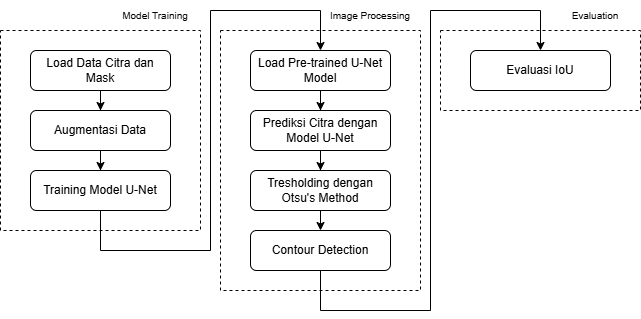

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Library Initialization**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#**Model Training**

##Load The Data

Load images and masks data used to train the U-Net model. Afterwards, split the data for training and testing.

In [ ]:
# Define paths
image_path = "/content/drive/MyDrive/Chest-X-Ray/image"  # Folder with chest X-ray images
mask_path = "/content/drive/MyDrive/Chest-X-Ray/mask"    # Folder with corresponding masks

# Load data
def load_data(image_path, mask_path, img_size=256):
    images = []
    masks = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size)) / 255.0
        images.append(img)

        mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size)) / 255.0
        masks.append(mask)

    images = np.expand_dims(np.array(images), axis=-1)
    masks = np.expand_dims(np.array(masks), axis=-1)
    return images, masks

# Load and split the data
X, Y = load_data(image_path, mask_path)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

##Data Augmentation

Augment the data while creating the training and validating dataset

In [ ]:
# Augmentation with Albumentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

def augment_data(image, mask):
    augmented = augmentations(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Data generator with augmentation
class DataGenerator(Sequence):
    def __init__(self, images, masks, batch_size=16, augment=False):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_masks = self.masks[start:end]

        if self.augment:
            augmented_images = []
            augmented_masks = []
            for img, mask in zip(batch_images, batch_masks):
                img, mask = augment_data(img, mask)
                augmented_images.append(img)
                augmented_masks.append(mask)
            batch_images = np.array(augmented_images)
            batch_masks = np.array(augmented_masks)

        return batch_images, batch_masks

train_generator = DataGenerator(X_train, Y_train, batch_size=16, augment=True)
validation_generator = DataGenerator(X_val, Y_val, batch_size=16, augment=False)

##U-Net Model Training

Initializing the U-Net model

In [ ]:
# U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs, outputs)

model = unet_model()

Compile the U-Net model

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

Train the U-Net model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=100
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 672ms/step - accuracy: 0.7755 - loss: 0.3764 - val_accuracy: 0.9070 - val_loss: 0.2999
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.8957 - loss: 0.3012 - val_accuracy: 0.9317 - val_loss: 0.2475
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 675ms/step - accuracy: 0.9208 - loss: 0.2339 - val_accuracy: 0.9402 - val_loss: 0.1685
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 689ms/step - accuracy: 0.9332 - loss: 0.1812 - val_accuracy: 0.9385 - val_loss: 0.1740
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 670ms/step - accuracy: 0.9301 - loss: 0.1867 - val_accurac

Save the U-Net model as HDF5 file

In [ ]:
# Save the model
model.save("lung_segmentation_unet.h5")

#**Image Processing**

##Model Loading

In [ ]:
# Load the saved model
model = load_model("/content/drive/MyDrive/Chest X Ray/lung_segmentation_unet.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Chest X Ray/lung_segmentation_unet.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

##Mask Prediction using U-Net Model

In [ ]:
def predict_mask(model, input_image, img_size=256):
    """
    Predict the mask for the input image using the model.

    Parameters:
        model: Trained U-Net model.
        input_image: Input image (numpy array, grayscale).
        img_size: Size to resize the input image for the model.

    Returns:
        predicted_mask: Mask predicted by the model.
    """
    resized_image = cv2.resize(input_image, (img_size, img_size)) / 255.0
    resized_image = np.expand_dims(resized_image, axis=(0, -1))  # Add batch and channel dimensions
    predicted_mask = model.predict(resized_image)[0, :, :, 0]  # First image in batch, remove extra dimensions
    return predicted_mask

##Post-processing

###Thresholding

In [ ]:
def threshold(predicted_mask):
    """
    Apply Otsu's thresholding to the predicted mask.

    Parameters:
        predicted_mask: Predicted mask from the model (float32 array).

    Returns:
        binary_mask: Binary mask after thresholding.
    """
    scaled_mask = (predicted_mask * 255).astype(np.uint8)
    _, binary_mask = cv2.threshold(scaled_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask

###Contour Detection

In [ ]:
def largest_contours(binary_mask, num_contours=2):
    """
    Detect the largest contours from the binary mask.

    Parameters:
        binary_mask: Binary mask after thresholding.
        num_contours: Number of largest contours to keep.

    Returns:
        largest_components: Binary mask with only the largest contours.
    """
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:num_contours]

    largest_components = np.zeros_like(binary_mask)
    for contour in sorted_contours:
        cv2.drawContours(largest_components, [contour], -1, 255, thickness=cv2.FILLED)
    return largest_components

##Creating Mask for CXR Image

In [ ]:
def process_image_and_create_mask(model, input_image, img_size=256, num_contours=2):
    """
    Process an image to create a binary mask with the largest contours.

    Parameters:
        model: Trained U-Net model.
        input_image: Input image (numpy array, grayscale).
        img_size: Size to resize the input image for the model.
        num_contours: Number of largest contours to keep.

    Returns:
        processed_mask: Binary mask with the largest contours.
    """
    # Step 1: Predict the mask
    predicted_mask = predict_mask(model, input_image, img_size)

    # Step 2: Apply thresholding
    binary_mask = threshold(predicted_mask)

    # Step 3: Detect largest contours
    processed_mask = largest_contours(binary_mask, num_contours)

    return predicted_mask, binary_mask, processed_mask

In [ ]:
# Load input image
input_image = cv2.imread("/content/drive/MyDrive/Chest-X-Ray/image/1555.png", cv2.IMREAD_GRAYSCALE)
mask_image = cv2.imread("/content/drive/MyDrive/Chest-X-Ray/mask/1555.png", cv2.IMREAD_GRAYSCALE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


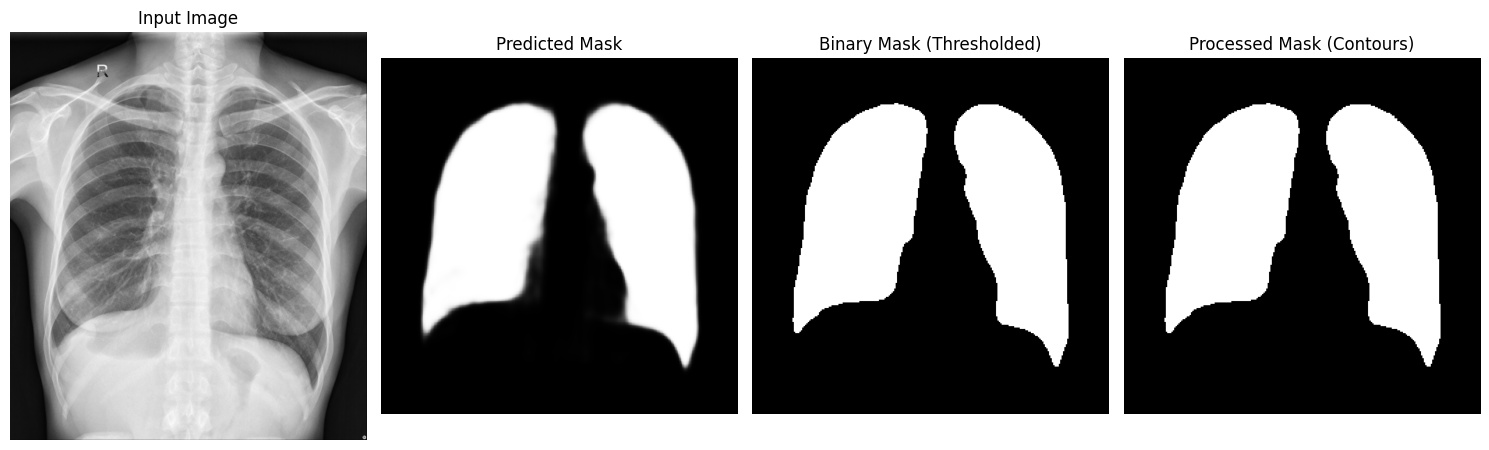

In [ ]:
# Process the image and generate masks
predicted_mask, binary_mask, processed_mask = process_image_and_create_mask(model, input_image)

# Visualize intermediate and final results
plt.figure(figsize=(15, 10))

plt.subplot(1, 4, 1)
plt.title("Input Image")
plt.imshow(input_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Binary Mask (Thresholded)")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Processed Mask (Contours)")
plt.imshow(processed_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

#**Evaluasi**

In [ ]:
def calculate_iou(predicted_image, real_mask):
    # Resize predicted_image to match real_mask's dimensions
    predicted_image = cv2.resize(predicted_image, (real_mask.shape[1], real_mask.shape[0]))

    # Konversi gambar ke binary jika belum (nilai 0 dan 255)
    predicted_binary = (predicted_image > 128).astype(np.uint8)
    real_binary = (real_mask > 128).astype(np.uint8)

    # Hitung Intersection dan Union
    intersection = np.logical_and(predicted_binary, real_binary).sum()
    union = np.logical_or(predicted_binary, real_binary).sum()

    # IoU calculation
    iou = intersection / union if union != 0 else 0
    return iou

iou_score = calculate_iou(processed_mask, mask_image) # Pass thresholded_image and mask_image
print(f"IoU Score: {iou_score:.2f}")

IoU Score: 0.94


In [ ]:
def compute_iou(y_true, y_pred, smooth=1e-10):
    """
    Compute Intersection over Union (IoU) for a single image.

    Args:
        y_true: Ground truth mask (binary).
        y_pred: Predicted mask (binary).
        smooth: Small constant to avoid division by zero.

    Returns:
        IoU score.
    """
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [ ]:
import os
import cv2
import numpy as np

def load_data_from_folder(image_folder, mask_folder, img_size=256):
    """
    Load images and masks from folders.

    Args:
        image_folder: Path to the folder containing images.
        mask_folder: Path to the folder containing masks.
        img_size: Size to which images and masks will be resized.

    Returns:
        Tuple of numpy arrays: (images, masks).
    """
    images = []
    masks = []
    for file in os.listdir(image_folder):
        # Load and preprocess the image
        img_path = os.path.join(image_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size)) / 255.0  # Normalize to [0, 1]
        images.append(np.expand_dims(img, axis=-1))  # Add channel dimension

        # Load and preprocess the corresponding mask
        mask_path = os.path.join(mask_folder, file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size)) / 255.0  # Normalize to [0, 1]
        masks.append(np.expand_dims(mask, axis=-1))  # Add channel dimension

    return np.array(images), np.array(masks)


def evaluate_mean_iou_from_folders(model, image_folder, mask_folder, img_size=256):
    """
    Evaluate mean IoU by loading data from folders.

    Args:
        model: Trained U-Net model.
        image_folder: Path to the folder containing images.
        mask_folder: Path to the folder containing masks.
        img_size: Size to which images and masks will be resized.

    Returns:
        Mean IoU score for the dataset.
    """
    # Load data
    images, masks = load_data_from_folder(image_folder, mask_folder, img_size)

    # Predict masks
    predictions = model.predict(images, verbose=1)
    predictions = (predictions > 0.5).astype(np.uint8)  # Threshold to binary masks
    masks = (masks > 0.5).astype(np.uint8)  # Ensure binary masks

    # Compute IoU for each image
    iou_scores = []
    for y_true, y_pred in zip(masks, predictions):
        iou = compute_iou(y_true.flatten(), y_pred.flatten())
        iou_scores.append(iou)

    # Calculate and return mean IoU
    mean_iou = np.mean(iou_scores)
    return mean_iou

# Paths to the Google Drive folders
image_folder = "/content/drive/MyDrive/Chest-X-Ray/image"  # Update with your folder path
mask_folder = "/content/drive/MyDrive/Chest-X-Ray/mask"   # Update with your folder path

# Evaluate the model
mean_iou = evaluate_mean_iou_from_folders(model, image_folder, mask_folder)
print(f"Mean IoU on Validation Dataset: {mean_iou:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
Mean IoU on Validation Dataset: 0.9274
